<a href="https://www.kaggle.com/code/llkh0a/who-will-survive-predict-titanic-survival?scriptVersionId=244411584" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Titanic Survival Prediction

This notebook focuses on building a machine learning model to predict survival on the Titanic. It includes feature engineering, model training, and evaluation. The goal is to create an accurate and interpretable model using ensemble techniques like *Random Forest* and *Gradient Boosting*.

***I appreciate you 🫵 for reading my notebook. Have a nice day/afternoon/night. Please upvote. 🙏***

![](https://i.imgur.com/uwUxbO1.png)

using the gender_submission from kaggle (male: 0, female: 1) can score 0.76 which is very high! 🤔
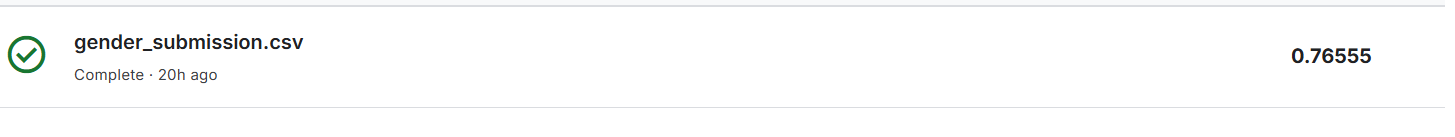
objective of this notebook is to achieve higher score than that!

so the first version already get a good score of:0.7894 which placed me at 1576/16751 in the leaderboard


i've added more params in the lastest version!

# Exploratory Data Analysis (EDA)

Before diving into feature engineering and modeling, a comprehensive Exploratory Data Analysis (EDA) was conducted to understand the data better. You can find the detailed EDA in the following notebook: [🚢 Titanic Survival Analysis: Insights](https://www.kaggle.com/code/llkh0a/titanic-survival-analysis-insights)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
# Suppress warnings globally
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load the datasets
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
train_data.head()

# Age Value Imputation ✨

and the age value is related to Pclass, Sex, Title. For example:

- 🎩 First-class male passengers with "Mr" titles tend to be sophisticated businessmen in their prime (median age ~42 years)
- 💎 First-class female passengers with "Mrs" titles are elegant society women with status (median age ~40 years)
- 💪 Third-class male passengers with "Mr" titles are often young, ambitious workers chasing dreams (median age ~26 years)
- 👶 Second-class children with "Master" titles are adorable little boys just starting life's journey (median age ~2 years)
- 👒 Unmarried women ("Miss") in second class are vibrant young ladies in their early twenties (median age ~21 years)
- 👩‍👧 Third-class females with "Mrs" titles are hardworking young mothers and wives (median age ~31 years)

These fascinating relationships paint a vivid picture of life aboard the Titanic! 🚢 By cleverly grouping passengers according to these telling characteristics, we can make much more accurate guesses about missing age values than just using a boring overall average. It's like being a detective solving the mysteries of missing data! 🕵️‍♀️

frist, let's create the `title` column

In [ ]:
def create_title_feature(data):
    # Create a copy to avoid modifying the original
    data = data.copy()
    
    # Extract title from name using regex
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Group rare titles
    rare_titles = ['Dona', 'Lady', 'Countess', 'Capt', 'Col', 'Don', 
                  'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']
    
    # Normalize titles
    data['Title'] = data['Title'].replace(['Mlle', 'Ms'], 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')
    data['Title'] = data['Title'].replace(rare_titles, 'Rare')
    
    # Encode titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    data['Title'] = data['Title'].map(title_mapping)
    data['Title'] = data['Title'].fillna(0)
    
    return data

In [ ]:
def fill_missing_age(data):
    # Create a copy to avoid modifying the original
    data = data.copy()
    
    # Calculate group medians based on Pclass, Sex, and Title
    age_fill = data.groupby(['Pclass', 'Sex', 'Title'])['Age'].median().reset_index()
    age_fill = age_fill.rename(columns={'Age': 'AgeMedian'})
    
    # Merge with original data
    data = data.merge(age_fill, on=['Pclass', 'Sex', 'Title'], how='left')
    
    # Create a mask for rows with missing Age
    age_missing_mask = data['Age'].isna()
    
    # For those rows, fill with median + random normal noise
    if age_missing_mask.any():
        # Set seed for reproducibility
        np.random.seed(42)
        
        # Add noise with standard deviation of 2 years (adjust as needed)
        random_noise = np.random.normal(0, 2, size=age_missing_mask.sum())
        data.loc[age_missing_mask, 'Age'] = data.loc[age_missing_mask, 'AgeMedian'] + random_noise
    
    # Ensure ages are within reasonable bounds
    data['Age'] = data['Age'].clip(lower=0.1, upper=80)
    
    # Drop temporary column
    data.drop('AgeMedian', axis=1, inplace=True)
    
    return data

In [ ]:
train_data = create_title_feature(train_data)
train_data = fill_missing_age(train_data)
train_data['Age'] = train_data['Age'].astype(int)

test_data = create_title_feature(test_data)
test_data = fill_missing_age(test_data)
test_data['Age'] = test_data['Age'].astype(int)

In [ ]:
old_train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
#sketch distribution of age for both data
plt.figure(figsize=(8, 4))
sns.histplot(old_train_data['Age'],kde=True, color='blue')
plt.title('Original Age Distribution')
plt.xlabel('Age')
#sketch distribution of age for both data
plt.figure(figsize=(8, 4))
sns.histplot(train_data['Age'],kde=True, color='red')
plt.title('Imputed Age Distribution')
plt.xlabel('Age')


In [ ]:
# Distribution of survival by Title
plt.figure(figsize=(8, 4))
sns.barplot(data=train_data, x='Title', y='Survived', ci=None, palette='viridis')
plt.title('Survival Distribution by Title')
plt.xlabel('Title')
plt.ylabel('Survival Rate')
plt.show()

# Feature Engineering
Based on the insights from the EDA, we will create new features to enhance the predictive power of our model.

In [ ]:
def engineer_features(data):
    # Create a copy to avoid modifying the original
    data = data.copy()
    
    # Family features
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = (data['FamilySize'] == 1).astype(int)
    
    # Handle categorical features
    data['Sex'] = data['Sex'].map({'female': 0, 'male': 1})
    
    # Fill missing Embarked values with most common
    data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
    data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    
    # Fill missing Fare values with median
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())
    
    # Create bins for continuous variables
    data['FareBin'] = pd.qcut(data['Fare'], 4, labels=False)
    data['AgeBin'] = pd.cut(data['Age'], 5, labels=False)
    
    return data

In [ ]:
# Apply the preprocessing function to both train and test datasets
train_data = engineer_features(train_data)
test_data = engineer_features(test_data)

In [ ]:
train_data.head()

In [ ]:
#print sumna
train_data.isna().sum()

### Notes on Feature Engineering
- **FamilySize**: Combines `SibSp` and `Parch` to represent the total number of family members onboard.
- **AgeBucket**: Groups ages into meaningful categories to capture age-related survival patterns.
- **FareBucket**: Divides fares into quartiles to capture the relationship between fare and survival.
- **Title**: Extracts titles (e.g., Mr., Mrs., Miss) from the `Name` column to capture social status and gender.

# Ensemble Modeling: Random Forest + Gradient Boosting
In this section, we will build an ensemble model combining Random Forest and Gradient Boosting to predict survival on the Titanic.

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Prepare the data
X = train_data.drop(['Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
y = train_data['Survived']

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['Sex', 'Embarked', 'Pclass','Title'], drop_first=True)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Hyper-params tuning

In [ ]:
# Hyperparameter tuning for Random Forest and Gradient Boosting
from sklearn.model_selection import GridSearchCV

# Define parameter grids
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.8],
}
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 0.8],
}

# Perform GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)
best_rf = rf_grid_search.best_estimator_

# Perform GridSearchCV for Gradient Boosting
gb_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid, cv=3, scoring='accuracy')
gb_grid_search.fit(X_train, y_train)
best_gb = gb_grid_search.best_estimator_


In [ ]:
#print best parameters
print("Best Random Forest Parameters:", rf_grid_search.best_params_)
print("Best Gradient Boosting Parameters:", gb_grid_search.best_params_)

In [ ]:

# Use the best models for ensemble
ensemble_model = VotingClassifier(estimators=[
    ('rf', best_rf),
    ('gb', best_gb)
], voting='soft')

## 🚈 training

In [ ]:
# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Evaluate the model
y_pred = ensemble_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))

# make predict on test set

In [ ]:
# Make predictions on the test set
X_test_final = test_data.drop(['Name', 'Ticket', 'Cabin'], axis=1)
X_test_final = pd.get_dummies(X_test_final, columns=['Sex', 'Embarked', 'Pclass','Title'], drop_first=True)

# # Ensure the test set has the same features as the training set
# missing_cols = set(X_train.columns) - set(X_test_final.columns)
# for col in missing_cols:
#     X_test_final[col] = 0
# X_test_final = X_test_final[X_train.columns]

# Predict using the ensemble model
test_predictions = ensemble_model.predict(X_test_final)

# Prepare the submission file
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_predictions
})
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")